# Clasificando con Redes Neuronales Convolucionales en Keras.

(c) 2022 Frnacisco José Madrid Cuevas <fjmadrid@uco.es>. Universidad de Córdoba. España.

Este cuaderno te permitirá practicar con varios modelos de Red Neuronal Convolucional (**CNN**) para resolver un problema de clasificación.

Vamos a utilizar el paquete TensorFlow con la interfaz Keras que permite manejar este tipo de modelos de una forma muy intuitiva.

Quizás sería interesante, antes de continuar, que repases en qué consiste una Red Neuronal Convolucional. Estos enlaces [1](https://algobeans.com/2016/03/13/how-do-computers-recognise-handwriting-using-artificial-neural-networks/) y [2](https://en.wikipedia.org/wiki/Convolutional_neural_network) pueden servirte para ello. 

Vamos a resolver un problema clásico que consiste en clasificar correctamente imágenes de histopatología. En la siguiente figura puedes ver ejemplos de las cuatro categorías que hay en el dataset.

![Ejemplo del dataset](https://production-media.paperswithcode.com/datasets/238b8867-fa08-4281-8a53-ca1851132301.png)

Nosotros vamos a trabajar con una versión del [dataset original](https://bupt-ai-cz.github.io/HSA-NRL/) con las imágenes escaladas a 128x128.



Lo primero será cargar los módulos python necesarios. Usaremos *TensorFlow* con la interfaz *Keras*. Además usaremos *Numpy* para manipular los datos y *Matplotlib* para generar gráficos.

In [9]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [10]:
print("Tensorflow version ", tf.__version__)
print("Keras version ",keras.__version__)

Tensorflow version  2.9.2
Keras version  2.9.0


## Descargar y preparar el Dataset.

Vamos a descargar y preparar el dataset para poder utilizarlo.

In [11]:
%%bash
#Descargar el dataset
pip install -U gdown
gdown -O fsiv_histopathology.zip 17owS_qJ9RPGek32w2-YmFUu2ooNKWrQz
pwd
unzip fsiv_histopathology.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/content
Archive:  fsiv_histopathology.zip
   creating: dataset/
  inflating: dataset/test_labels.txt  
  inflating: dataset/README.md       
   creating: dataset/test_128/
  inflating: dataset/test_128/537690_1-IMG010x010-0.JPG  
  inflating: dataset/test_128/539085_2-IMG014x007-1.JPG  
  inflating: dataset/test_128/538842_1-IMG010x009-0.JPG  
  inflating: dataset/test_128/543086_1-IMG023x020-2.JPG  
  inflating: dataset/test_128/539972_2-IMG010x043-0.JPG  
  inflating: dataset/test_128/539972_2-IMG006x033-0.JPG  
  inflating: dataset/test_128/538842_1-IMG015x012-0.JPG  
  inflating: dataset/test_128/536828-IMG008x006-1.JPG  
  inflating: dataset/test_128/538880-3-IMG034x022-1.JPG  
  inflating: dataset/test_128/538880-3-IMG006x021-3.JPG  
  

Downloading...
From: https://drive.google.com/uc?id=17owS_qJ9RPGek32w2-YmFUu2ooNKWrQz
To: /content/fsiv_histopathology.zip
100%|██████████| 72.5M/72.5M [00:00<00:00, 152MB/s]


Ahora vamos a cargar y preparar el dataset. Primero definiremos algunas funciones de utilidad.

In [12]:
def load_dataset(dirname, partition='train'):
    """
    Load the a partition of the histopatology dataset.

    Params:

    dirname: string
       Is the pathname of the datset.

    partition: string
        Specify which partion to load. Allowed values 'train' or 'test'.

    Return:
        X: numpy.ndarray
            The samples (one per row)
        y: numpy.ndarray
            The labels (one per row)
    """
    flabels = open(dirname + '/' + partition + '_labels.txt')
    lines = flabels.readlines()
    X = np.empty((len(lines), 128, 128, 3), 'f')
    y = np.empty((len(lines),), 'i')
    count = 0
    for line in lines:        
        data = line.split(' ')        
        img_fname = dirname + '/' + data[0]
        img = cv2.imread(img_fname, cv2.IMREAD_COLOR).astype('f')/255.0
        label = int(data[1])
        X[count] = img
        y[count] = label
        count += 1
    return X, y

N_CLASSES=4
SAMPLE_SHAPE = (128, 128, 3)
label_names = ["Normal", "Serrated", "Adenocarcinoma", "Adenoma"]
X, y = load_dataset('/content/dataset', 'train')

Vamos a ver algunas de las imágenes.

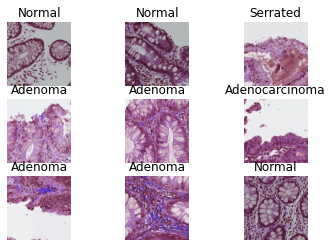

In [13]:
fig, axes = plt.subplots(3, 3)
for r in range(3):
  for c in range(3):
    idx = np.random.randint(X.shape[0])    
    axes[r,c].axis(False)
    axes[r,c].set_title(label_names[y[idx]])
    axes[r,c].imshow(X[idx])


### Preprando las etiquetas

Tenemos cuatro clases con etiquetas con valores enteros en el rango [0...3]. 

Nuestra CNN tendrá como capa de salida 4 neuronas asignando una categoría por neurona, siendo la clase predicha la correspondiente a la neurona con mayor respuesta.

Para calcular el error cometido en la predicción vamos a transformar las etiquetas enteras a un vector con cuatro valores 0|1 que codifica la etiqueta correspondiente. Por ejemplo la etiqueta 0 se convierte al vector (1,0,0,0), la etiqueta 1 será (0,1,0,0) y así sucesivamente. De esta forma podremos utilizar la función de pérdida `categorical-crossentropy` comparar la salida de la CNN con el valor esperado.

In [14]:
y = keras.utils.to_categorical(y, N_CLASSES)

## Creación del modelo

Ahora toca crear nuestro modelo CNN para resolver el problema. Vamos a crear varios modelos desde el más simple con un bloque convolucional y una capa oculta totalmente conectada al más complejo con más bloques convolucionales y varias capas ocultas densas.

En los tres modelos usaremos en las capas ocultas, la función de activación '*Relu*' sin '*bias*'. La capa de salida tendrá diez neuronas, cada una representará un dígito posible y usaremos la función de activación '*softmax*'.

In [29]:
def create_model1():  
  model = keras.Sequential(      
      [keras.Input(shape=SAMPLE_SHAPE, name='Input'),
       #TODO: Añade aquí los bloques convolucionales que desees.

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       keras.layers.Activation('relu', name='Relu1'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       #
       #Red final densa.
       keras.layers.Flatten(),
       #TODO: Añade aquí las capas ocultas que desees.

       keras.layers.Dense(640, activation='relu', name='Dense1'),

       #
       keras.layers.Dense(4, activation='softmax', name='Ouput')
      ], name= 'Model1')
  return model

#TODO: crea otros modelos
def create_model2():
  model = keras.Sequential(      
      [keras.Input(shape=SAMPLE_SHAPE, name='Input'),
       #TODO: Añade aquí los bloques convolucionales que desees.

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       keras.layers.Activation('relu', name='Relu1'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv2'),
       keras.layers.Activation('relu', name='Relu2'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool2'),

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv3'),
       keras.layers.Activation('relu', name='Relu3'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool3'),

       #
       #Red final densa.
       keras.layers.Flatten(),
       #TODO: Añade aquí las capas ocultas que desees.

       keras.layers.Dense(640, activation='relu', name='Dense1'),
       keras.layers.Dense(640, activation='relu', name='Dense2'),
       keras.layers.Dense(640, activation='relu', name='Dense3'),

       #
       keras.layers.Dense(4, activation='softmax', name='Ouput')
      ], name= 'Model2')
  return model
# ...

def create_model3():
  model = keras.Sequential(      
      [keras.Input(shape=SAMPLE_SHAPE, name='Input'),
       #TODO: Añade aquí los bloques convolucionales que desees.

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       keras.layers.Activation('relu', name='Relu1'),
       keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv2'),
       keras.layers.Activation('relu', name='Relu2'),
       keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), name='Pool2'),

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv3'),
       keras.layers.Activation('relu', name='Relu3'),
       keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), name='Pool3'),

       #
       #Red final densa.
       keras.layers.Flatten(),
       #TODO: Añade aquí las capas ocultas que desees.

       keras.layers.Dense(640, activation='relu', name='Dense1'),
       keras.layers.Dense(640, activation='relu', name='Dense2'),
       keras.layers.Dense(640, activation='relu', name='Dense3'),

       #
       keras.layers.Dense(4, activation='softmax', name='Ouput')
      ], name= 'Model3')
  return model


def create_model4():
  model = keras.Sequential(      
      [keras.Input(shape=SAMPLE_SHAPE, name='Input'),
       #TODO: Añade aquí los bloques convolucionales que desees.

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       keras.layers.Activation('relu', name='Relu1'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv2'),
       keras.layers.Activation('relu', name='Relu2'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool2'),
       
       keras.layers.Dropout(.2, input_shape=(2,), name='Drop1'),

       keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv3'),
       keras.layers.Activation('relu', name='Relu3'),
       keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool3'),

       #
       #Red final densa.
       keras.layers.Flatten(),
       #TODO: Añade aquí las capas ocultas que desees.

       keras.layers.Dense(640, activation='relu', name='Dense1'),
       keras.layers.Dense(640, activation='relu', name='Dense2'),
       keras.layers.Dense(640, activation='relu', name='Dense3'),

       #
       keras.layers.Dense(4, activation='softmax', name='Ouput')
      ], name= 'Model4')
  return model

Seleccinonamos el modelo que vamos a entrenar.

In [30]:
#Activa/Desactiva comentario para seleccionar el modelo deseado.
#model = create_model1()
#model = create_model2()
#model = create_model3()
model = create_model4()

model.summary()

Model: "Model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 124, 124, 20)      1520      
                                                                 
 Relu1 (Activation)          (None, 124, 124, 20)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 62, 62, 20)        0         
                                                                 
 Conv2 (Conv2D)              (None, 58, 58, 20)        10020     
                                                                 
 Relu2 (Activation)          (None, 58, 58, 20)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 29, 29, 20)        0         
                                                                 
 Drop1 (Dropout)             (None, 29, 29, 20)        0    

## Prepación del modelo.

Ahora vamos a preparar el modelo para entrenarlo. Para ello debemos indicar tres cosas principalmente:
- **La función de pérdida a utilizar**. La función de pérdida mide la "distancia" entre la predicción que da la red para una muestra y el valor de verdad anotado. Cuanto menor sea esa distancia mejor ya que la red predice valores muy próximos a la salidas esperadas (*Ground Truth*). Nosotros vamos a utilizar como métrica la entropía cruzada para N categorias. En este [enlace](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451) puedes ver más detalles.
- **El algoritmo optimizador**. El optimizador es el algoritmo que va ajustando, de foma iterativa, los parámetros del modelo buscando un mínimo de la función de pérdida. Inicialmente se suele utilizar el algoritmo SGD (Stochastic Gradient Descent). Dependiendo del algoritmo elegido, podremos indicar más parámetros. Nosotros usaremos los parámetros por defecto para el algoritmo SGD.
- **Una o varias métricas**. Una métrica mide lo bien que funciona nuestro modelo. Si la red es para clasificar y las clases están balanceadas (es decir, tenemos más o menos las mismas muestras para entrenar por clase) se suele utilizar como métrica la exactitud (*accuracy*). Puedes ver más detalles en este [enlace](https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion).

In [31]:
#TODO: prueba otro optimizador o cambia parámetros del optimizador como por ejemplo el 'learning rate'.
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(),
              metrics='accuracy')

## Entrenamiento del modelo.

Ahora vamos a realizar el entrenamiento. Vamos a repetir ciclos (épocas) para presentar los datos de entrenamiento por paquetes (*bacth*) para que el optimizador vaya modificando los parámetros del modelo (p. e. los pesos de las conexiones entre capas) buscando un mínimo local de la función de pérdida. Al final de cada época se evaluará el *accuracy* conseguido. Para ello, en cada época se dejará un porción del conjunto de entrenamiento para validar al final.

El comportamiento deseable es que el valor de la función de la pérdida para los datos de entrenamiento y validación vayan descendiendo conforme vayan pasando épocas.

In [32]:
BATCH_SIZE = 128
N_EPOCH = 50
VALIDATION_SIZE = 0.2
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=N_EPOCH,
                    validation_split=VALIDATION_SIZE)

Epoch 1/50
14/14 [==============================] - 2s 85ms/step - loss: 1.3287 - accuracy: 0.3957 - val_loss: 1.3458 - val_accuracy: 0.0000e+00
Epoch 2/50
14/14 [==============================] - 1s 55ms/step - loss: 1.2850 - accuracy: 0.4120 - val_loss: 1.3798 - val_accuracy: 0.0000e+00
Epoch 3/50
14/14 [==============================] - 1s 56ms/step - loss: 1.2841 - accuracy: 0.4120 - val_loss: 1.4405 - val_accuracy: 0.0000e+00
Epoch 4/50
14/14 [==============================] - 1s 56ms/step - loss: 1.2841 - accuracy: 0.4120 - val_loss: 1.3716 - val_accuracy: 0.0000e+00
Epoch 5/50
14/14 [==============================] - 1s 55ms/step - loss: 1.2796 - accuracy: 0.4120 - val_loss: 1.3294 - val_accuracy: 0.0000e+00
Epoch 6/50
14/14 [==============================] - 1s 55ms/step - loss: 1.2788 - accuracy: 0.4120 - val_loss: 1.3527 - val_accuracy: 0.0000e+00
Epoch 7/50
14/14 [==============================] - 1s 55ms/step - loss: 1.2724 - accuracy: 0.4120 - val_loss: 1.3793 - val_accura

Vamos a mostrar dos gráficos. Uno muestra la evolución de la función de pérdida y el otro la evolución del *accuracy* en las particiones de train/validation.

Estos gráficos permiten evaluar el balance "Sesgo versus Varianza" (*Bias vs. Variance*) de nuestro modelo.

Al principio del entrenamiento, el modelo tendrá un valor de métrica muy pobre, es decir, tendrá un valor alto de sesgo (*underfitting*). Conforme progrese el entrenamiento se irá reduciendo el sesgo. Suele ocurrir, sobre todo cuanto más complejo es el modelo entrenado, que a partir de un punto, la diferencia de la métrica para el conjunto de entrenamiento y para el conjunto de validación comenzará a aumentar, es decir aumentará la varianza. Esto indica que el modelo está *sobre-entrenando* (*overfitting*) y perdiendo poder de generalización, siendo esto una situación no deseable.

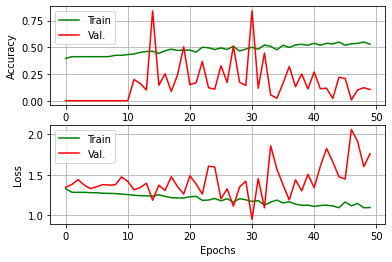

In [33]:
fig, axes = plt.subplots(2, 1)
axes[0].grid(True)
axes[0].set_ylabel('Accuracy')
axes[0].plot(history.history['accuracy'], 'g-', label='Train')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val.')
axes[0].legend()
axes[1].grid(True)
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].plot(history.history['loss'], 'g-', label='Train')
axes[1].plot(history.history['val_loss'], 'r-', label='Val.')
axes[1].legend()

## Evaluación.

Una vez que tenemos nuestro modelo entrenado intentado obtener el mejor balance "Sesgo/Varianza", es hora de evaluar el poder de generalización que ha conseguido. Para ello utilizaremos las muestras de la partición para Test. Nótese que estas muestras no han sido vistas por nuestro modelo nunca y por lo tanto, el resultado obtenido permitirá tener una estimación de cómo se comportará el modelo en "explotación".

También esta evaluación permitirá comparar de forma justa nuestro modelo con otros modelos entrenados, ya que si utilizamos las métricas obtenidas en la fase de entrenamiento para esto, podrímos llegar a conclusiones equivocadas.

In [34]:
X, y = load_dataset('/content/dataset', 'test')
y = keras.utils.to_categorical(y, N_CLASSES)
score = model.evaluate(X, y)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 1s 8ms/step - loss: 1.2353 - accuracy: 0.4558
Test loss: 1.2352806329727173
Test accuracy: 0.4558204710483551
